In [135]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader  
from albumentations import RandomCrop, HorizontalFlip, CenterCrop, Compose, Normalize
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.metrics import accuracy_score

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

print(os.listdir('stanford-dogs-dataset'))

['images', 'annotations']


# Preprocessing
all code in this section adapted from https://www.kaggle.com/virajbagal/stanford-dogs-alexnet-paper-implementation-pytorch

### Load augmented stanford dogs dataset
Prior to loading, each subfolder inside mixed_breeds was dropped in /stanford-dogs-dataset/images/Images. There are no annotations for these 20 extra breeds. file name and parental info for these 20 mixed breeds is in mixed_breeds.csv.

In [246]:
annot_path = 'stanford-dogs-dataset/annotations/Annotation'
image_path = 'stanford-dogs-dataset/images/Images'

In [249]:
print('Length of annotations :', len(os.listdir(annot_path)))
print('Length of image classes :', len(os.listdir(image_path)))
if len(os.listdir(annot_path)) == len(os.listdir(image_path)):
    print('Number of unique annotations matches the number of classes')
else:
    print("Number of unique annotations doesn't match the number of classes")

Length of annotations : 120
Length of image classes : 140
Number of unique annotations doesn't match the number of classes


In [250]:
valid = []

for element in os.listdir(image_path):
    breed = element.split('-')[1]
    images = len(os.listdir(os.path.join(image_path,element)))
    valid.append((breed, images))

In [256]:
df = pd.DataFrame(valid, columns = ['Breeds', 'Number of images'])
print('Total number of images :', df['Number of images'].sum())

Total number of images : 20980


In [257]:
df.head()

,Breeds,Number of images
0,silky_terrier,183
1,Scottish_deerhound,232
2,Chesapeake_Bay_retriever,167
3,Ibizan_hound,188
4,wire,157


### Preprocess combined dataset

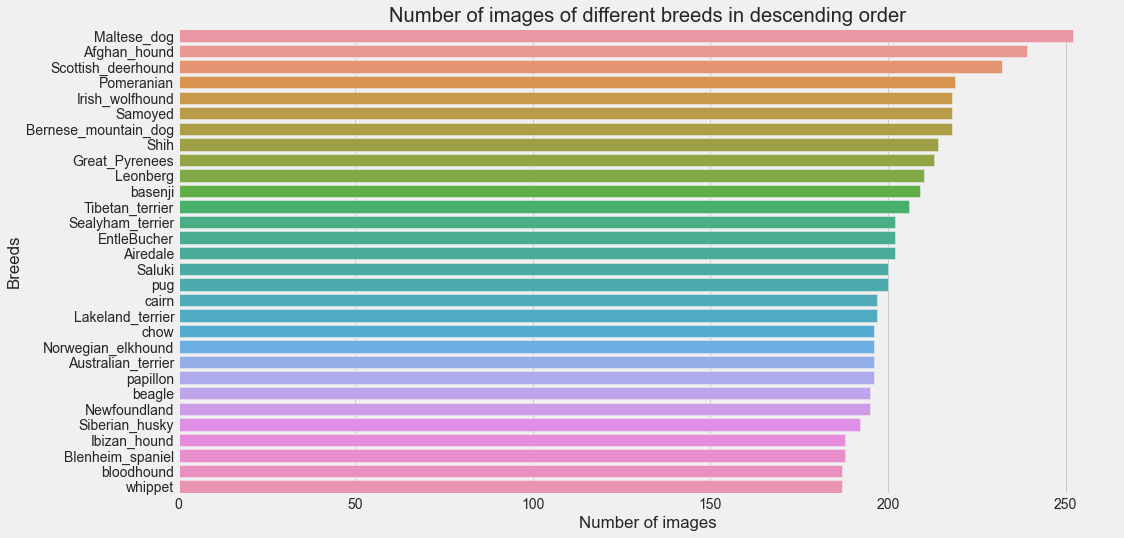

In [258]:
plt.figure(figsize=(15,8))
plt.title('Number of images of different breeds in descending order')
sns.barplot(x = 'Number of images', y = 'Breeds', data = df.sort_values('Number of images', ascending = False).head(30))
plt.show()

In [259]:
# temporary- only use 5 pure breeds and 5 mixed breeds
subset = df.sort_values('Number of images', ascending = False)['Breeds'][:5].values.tolist()
subset2 = df.sort_values('Number of images', ascending = True)['Breeds'][:5].values.tolist()

In [260]:
subset

['Maltese_dog',
 'Afghan_hound',
 'Scottish_deerhound',
 'Pomeranian',
 'Irish_wolfhound']

In [261]:
subset2

['sammypoo', 'mal_shi', 'labradoodle', 'pomsky', 'golden_labrador']

In [262]:
valid = []

for element in os.listdir(image_path):
    if element.split('-')[1] in subset or element.split('-')[1] in subset2:
        for img_id in os.listdir(os.path.join(image_path, element)):
            path = os.path.join(element, img_id)
            label = element.split('-')[1]
            valid.append((path, label))          
        
df = pd.DataFrame(valid, columns = ['Path', 'Label'])
print('Shape of dataframe :', df.shape)

Shape of dataframe : (1260, 2)


In [263]:
# Dataset with the suffix path and label

df.head()

,Path,Label
0,n02092002-Scottish_deerhound/n02092002_2981.jpg,Scottish_deerhound
1,n02092002-Scottish_deerhound/n02092002_6503.jpg,Scottish_deerhound
2,n02092002-Scottish_deerhound/n02092002_11105.jpg,Scottish_deerhound
3,n02092002-Scottish_deerhound/n02092002_6729.jpg,Scottish_deerhound
4,n02092002-Scottish_deerhound/n02092002_12544.jpg,Scottish_deerhound


In [264]:
def aug1():
        return Compose([RandomCrop(height = 224, width = 224, p = 1.0), 
                        HorizontalFlip(p = 0.5),  
                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ToTensorV2()], p = 1)

In [265]:
def aug2():
    return Compose([Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                    ToTensorV2()], p = 1)

In [266]:
train_aug = aug1()
valid_aug = aug2()

### PCA Color Augmentation

This augmentation was used in the AlexNet paper. Following is the excerpt from AlexNet paper. 
For more information refer to Alexnet Paper : https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

To each RGB image pixel I xy =
R
G
B T
[I xy
, I xy
, I xy
] we add the following quantity:
[p 1 , p 2 , p 3 ][α 1 λ 1 , α 2 λ 2 , α 3 λ 3 ] T
where p i and λ i are ith eigenvector and eigenvalue of the 3 × 3 covariance matrix of RGB pixel
values, respectively, and α i is the aforementioned random variable

In [267]:
def PCAColorAug(image, category = 'Tensor'):
    if type(image) == torch.Tensor:
        image = image.numpy()
        image = np.moveaxis(image, 0, 2)
    
    
    img_reshaped = image.reshape(-1, 3).astype('float32')
    mean, std = np.mean(img_reshaped, 0), np.std(img_reshaped, 0)
    img_rescaled = (img_reshaped - mean)/std
    cov_matrix = np.cov(img_rescaled, rowvar = False) # Covariant matrix of reshaped image.  Output is 3*3 matrix
    eigen_val, eigen_vec = np.linalg.eig(cov_matrix) # Compute Eigen Values and Eigen Vectors of the covariant matrix. eigen_vec is 3*3 matrix with eigen vectors as column. 
    alphas = np.random.normal(loc = 0, scale = 0.1, size = 3)
    vec1 = alphas*eigen_val
    valid = np.dot(eigen_vec, vec1) # Matrix multiplication
    pca_aug_norm_image = img_rescaled + valid
    pca_aug_image = pca_aug_norm_image*std + mean
    aug_image = np.maximum(np.minimum(pca_aug_image, 255), 0).astype('uint8')
    if category == 'Tensor':
        return torch.from_numpy(aug_image.reshape(3,256,256))
    else:
        return aug_image.reshape(256,256,3)
    

In [268]:
labels = pd.get_dummies(df['Label'])

## DataSet

In [269]:
import torchvision.transforms as transforms

class StanfordDogs(Dataset):
    def __init__(self, transform1, transform2, X, Y, objective = 'train'):
        self.X = X
        self.Y = Y
        self.train_transform = transform1
        self.valid_transform = transform2
        self.objective = objective
        
    def __getitem__(self, idx):
        path = self.X['Path'][idx]
        label = self.Y.iloc[idx, :].values
        img = cv2.imread(os.path.join(image_path, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Shortest side of image is scaled to 256 pixels and the other side is scaled so as to maintain aspect ratio
        
        h, w, _ = img.shape
        
        if h <= w:
            aspect_ratio = w/h
            dim = (256, int(256*aspect_ratio))
            img = cv2.resize(img, dim)
        else:
            aspect_ratio = h/w
            dim = (int(256*aspect_ratio), 256)
            img = cv2.resize(img, dim)

           
        img = CenterCrop(height = 256, width = 256, p = 1)(image = img)['image']
        
        if self.objective == 'train':
            random = np.random.uniform(size = 1)
            if random < 0.5:                            # PCA Augmentation carried out only 50 percent of time
                img = PCAColorAug(img, category = 'numpy')
                
            augmented = self.train_transform(image = img)
            img = augmented['image']
            
            return img, label
        
        elif ((self.objective == 'validation') |  (self.objective == 'test')):
            img = cv2.resize(img, (224, 224))
            augmented = self.valid_transform(image = img)
            img = augmented['image']  
            
            return img, label
        
    
    def __len__(self):
        return len(self.X)

In [270]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df, labels, test_size = 0.25, random_state = 5, stratify = df['Label'])
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size = 0.25, random_state = 5, stratify = train_X['Label'])

In [271]:
train_X.reset_index(drop = True, inplace = True)
val_X.reset_index(drop = True, inplace = True)
test_X.reset_index(drop = True, inplace = True)

train_y.reset_index(drop = True, inplace = True)
val_y.reset_index(drop = True, inplace = True)
test_y.reset_index(drop = True, inplace = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

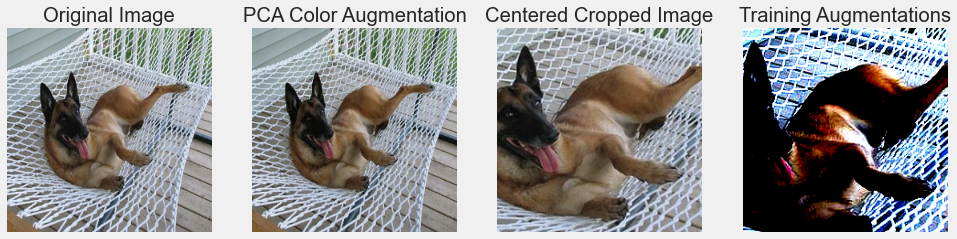

In [272]:
image = cv2.imread(image_path + '/n02105162-malinois/n02105162_6625.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image1 = cv2.resize(image, (256,256))
aug_image = PCAColorAug(image1, category = 'numpy')
cropped_img = CenterCrop(height = 256, width = 256, p = 1)(image = image)['image']
image2 = cv2.resize(cropped_img, (224,224))
image3 = train_aug(image = cropped_img)['image']
image3 = image3.numpy()
image3 = np.moveaxis(image3, 0, 2)
image3 = cv2.resize(image3, (224,224))

plt.figure(figsize = (15, 10))
plt.subplot(1,4,1)
plt.imshow(image1)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(aug_image)
plt.title('PCA Color Augmentation')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(image2)
plt.title('Centered Cropped Image')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(image3)
plt.title('Training Augmentations')
plt.axis('off')

In [273]:
BATCH_SIZE = 128

def loader(data_X, data_Y, batch_size = BATCH_SIZE, obj = 'train'):
    data = StanfordDogs(train_aug, valid_aug, X = data_X, Y = data_Y, objective = obj)
    loader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = True)
    
    return loader

In [274]:
train_loader = loader(train_X, train_y, batch_size = BATCH_SIZE)
val_loader = loader(val_X, val_y, batch_size = BATCH_SIZE, obj = 'validation')